Find the size of the NYC Taxi dataset we will be using.

In [11]:
from pathlib import Path

csv_file = Path('C:/Users/Lenovo/Desktop/datasets/yellow_tripdata_2022-01.parquet')

mb = 2**20
size = csv_file.stat().st_size / mb
print('The size of the dataset is {} MB.'.format(round(size,2)))

The size of the dataset is 36.37 MB.


Get the number of lines for the dataset.

In [236]:
import pandas as pd 

df = pd.read_parquet('C:/Users/Lenovo/Desktop/datasets/yellow_tripdata_2022-01.parquet')
print(f'{len(df):,}')

2,463,931


Check out the datatypes of the columns

In [41]:
df.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
dtype: object

What are the VendorIDs the dataset contains?

In [42]:
df.VendorID.unique()

array([1, 2, 6, 5], dtype=int64)

Rename the VendorIDs.

In [237]:
names = {
    1: 'A',
    2: 'B',
    5: 'C',
    6: 'D'
}

df['Vendor'] = df.VendorID.map(names)
df.Vendor.head()

0    A
1    A
2    B
3    B
4    B
Name: Vendor, dtype: object

Find the number of rides per Vendor.

In [44]:
df.groupby('Vendor').size()

Vendor
A     742273
B    1716059
C         36
D       5563
dtype: int64

How much memory does the new column take?

In [45]:
df['Vendor'].memory_usage(deep=True) / mb

136.28780937194824

136 MB is too much memory for a column. We can instead save the new string as a categorical data to save memory.

In [46]:
df['Vendor'] = (df.VendorID.map(names).astype('category'))
df['Vendor'].head()

0    A
1    A
2    B
3    B
4    B
Name: Vendor, dtype: category
Categories (4, object): ['A', 'B', 'C', 'D']

Check out the memory usage again.

In [50]:
df['Vendor'].memory_usage(deep=True) / mb

2.350295066833496

We down almost 95%. <br>
We can also retrieve the codes corresponding to the categories instead of their names.

In [52]:
df['Vendor'].head().cat.codes

0    0
1    0
2    1
3    1
4    1
dtype: int8

How many rides do the taxis have each day?

In [69]:
ride_days = df.groupby(df.tpep_pickup_datetime.dt.floor('D')).size()
ride_days

tpep_pickup_datetime
2008-12-31         6
2009-01-01         8
2021-12-31        24
2022-01-01     63441
2022-01-02     58421
2022-01-03     72405
2022-01-04     74562
2022-01-05     74592
2022-01-06     79909
2022-01-07     71590
2022-01-08     83177
2022-01-09     64014
2022-01-10     73692
2022-01-11     77603
2022-01-12     80352
2022-01-13     84952
2022-01-14     93817
2022-01-15     88704
2022-01-16     72783
2022-01-17     63518
2022-01-18     84603
2022-01-19     86640
2022-01-20     90778
2022-01-21    101054
2022-01-22     96587
2022-01-23     76914
2022-01-24     78541
2022-01-25     87349
2022-01-26     96747
2022-01-27     99766
2022-01-28     95873
2022-01-29     34388
2022-01-30     71229
2022-01-31     85878
2022-02-01         6
2022-02-22         1
2022-03-09         1
2022-03-15         3
2022-04-06         1
2022-05-18         2
dtype: int64

And we have spotted rides from 2008 and 2009. Drop those lines additionaly with rides from 2022-02 and onwards, then plot the rides per day.

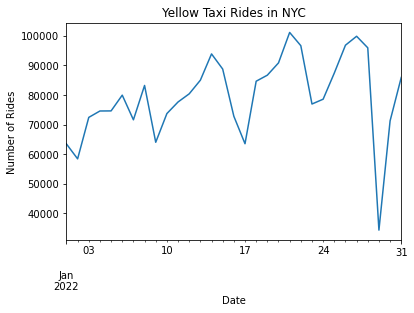

In [80]:
ride_days = ride_days[(ride_days.index >= '2022-01') & (ride_days.index <  '2022-02')]

ride_days.index.name = 'Date'
ride_days.plot(kind='line', title='Yellow Taxi Rides in NYC', ylabel='Number of Rides');

In [147]:
df['hour'] = df.tpep_pickup_datetime.dt.hour
df['day'] = df.tpep_pickup_datetime.dt.day

df[['day', 'hour']].head()

,day,hour
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


Get the hourly median ridese per hour and per Vendor.

In [188]:
jan_df = df[(df.tpep_pickup_datetime >= '2022-01') & (df.tpep_pickup_datetime <  '2022-02')]

vendor_count = jan_df.groupby(['Vendor', 'day', 'hour'], as_index=False).count()
vendor_hour  = vendor_hour.groupby(['Vendor', 'hour'], as_index=False)['VendorID'].median()
vendor_hour

,Vendor,hour,VendorID
0,A,0,383.0
1,A,1,204.0
2,A,2,107.0
3,A,3,88.0
4,A,4,84.0
...,...,...,...
91,D,19,4.0
92,D,20,3.0
93,D,21,2.0
94,D,22,3.0


First tranform the table into a pivot table and then plot the bar graph.

In [192]:
vendor_hour.pivot(index='hour', columns='Vendor', values='VendorID')

Vendor,A,B,C,D
hour,,,,
0,383.0,1030.0,0.0,1.0
1,204.0,525.0,0.0,1.0
2,107.0,312.0,0.0,0.0
3,88.0,198.0,0.0,1.0
4,84.0,180.0,0.0,1.0
5,155.0,312.0,0.0,4.0
6,457.0,920.0,0.0,9.0
7,997.0,1959.0,0.0,13.0
8,1263.0,2761.0,0.0,12.0


<AxesSubplot:xlabel='hour'>

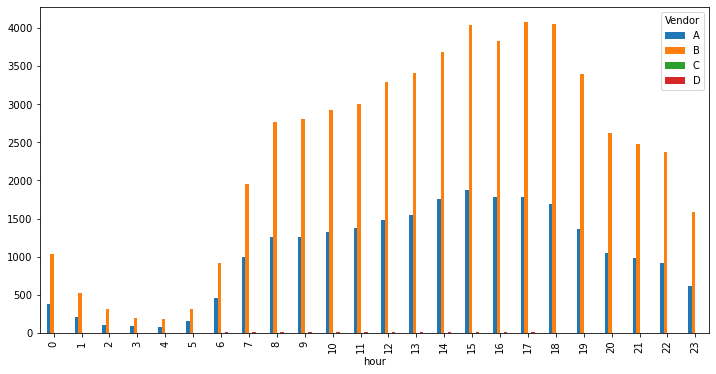

In [203]:
vendor_hour.pivot(index='hour', columns='Vendor', values='VendorID').plot.bar(figsize=(12, 6))

We can see that most rides happen during the day, and the night hours witnesses only a few rides.

Download daily weather data for NYC to see if there is a relation between ride counts and weather.

In [208]:
from urllib.request import urlretrieve
from pathlib import Path

here = Path(r'C:\Users\Lenovo\Desktop').absolute().parent
csv_file = here / 'weather.csv'

url = (
    'https://www.ncei.noaa.gov/data/'
    'global-historical-climatology-network-daily/access/USW00094789.csv'
)

out_name = '/'.join(csv_file.parts[-3:])
print(f'downloading weather to {out_name}')
urlretrieve(url, csv_file)

downloading weather to Users/Lenovo/weather.csv


(WindowsPath('C:/Users/Lenovo/weather.csv'),
 <http.client.HTTPMessage at 0x2039da47a30>)

In [229]:
weather_df = pd.read_csv('weather.csv', parse_dates=['DATE'], index_col='DATE')
weather_df.head()

<ipython-input-229-18bd272a5881>:1: DtypeWarning: Columns (17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53,55,69,75,77,79,81,83,85,87,89,91,93,95) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_df = pd.read_csv('weather.csv', parse_dates=['DATE'], index_col='DATE')


,STATION,LATITUDE,LONGITUDE,ELEVATION,NAME,PRCP,PRCP_ATTRIBUTES,SNOW,SNOW_ATTRIBUTES,SNWD,...,WT18,WT18_ATTRIBUTES,WT19,WT19_ATTRIBUTES,WT21,WT21_ATTRIBUTES,WT22,WT22_ATTRIBUTES,WV01,WV01_ATTRIBUTES
DATE,,,,,,,,,,,,,,,,,,,,,
1948-07-17,USW00094789,40.63915,-73.7639,2.7,"JFK INTERNATIONAL AIRPORT, NY US",15.0,",,X,",0.0,",,X,",0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948-07-18,USW00094789,40.63915,-73.7639,2.7,"JFK INTERNATIONAL AIRPORT, NY US",0.0,"T,,X,",0.0,",,X,",0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948-07-19,USW00094789,40.63915,-73.7639,2.7,"JFK INTERNATIONAL AIRPORT, NY US",0.0,"T,,X,",0.0,",,X,",0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948-07-20,USW00094789,40.63915,-73.7639,2.7,"JFK INTERNATIONAL AIRPORT, NY US",0.0,",,X,",0.0,",,X,",0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948-07-21,USW00094789,40.63915,-73.7639,2.7,"JFK INTERNATIONAL AIRPORT, NY US",622.0,",,X,",0.0,",,X,",0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As taxi dataset contains rides only for Jan, 2022, filter out the rows from the weather data that is not in that range.

In [231]:
weather_df = weather_df[(weather_df.index >= '2022-01') & (weather_df.index < '2022-02')]
weather_df.head(5)

,STATION,LATITUDE,LONGITUDE,ELEVATION,NAME,PRCP,PRCP_ATTRIBUTES,SNOW,SNOW_ATTRIBUTES,SNWD,...,WT18,WT18_ATTRIBUTES,WT19,WT19_ATTRIBUTES,WT21,WT21_ATTRIBUTES,WT22,WT22_ATTRIBUTES,WV01,WV01_ATTRIBUTES
DATE,,,,,,,,,,,,,,,,,,,,,
2022-01-01,USW00094789,40.63915,-73.7639,2.7,"JFK INTERNATIONAL AIRPORT, NY US",310.0,",,W,2400",0.0,",,W,2400",0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-02,USW00094789,40.63915,-73.7639,2.7,"JFK INTERNATIONAL AIRPORT, NY US",8.0,",,W,2400",0.0,",,W,2400",0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-03,USW00094789,40.63915,-73.7639,2.7,"JFK INTERNATIONAL AIRPORT, NY US",0.0,",,W,2400",0.0,",,W,2400",0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-04,USW00094789,40.63915,-73.7639,2.7,"JFK INTERNATIONAL AIRPORT, NY US",0.0,",,W,2400",0.0,",,W,2400",0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-05,USW00094789,40.63915,-73.7639,2.7,"JFK INTERNATIONAL AIRPORT, NY US",74.0,",,W,2400",0.0,"T,,W,2400",0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [232]:
weather_df.describe()

,LATITUDE,LONGITUDE,ELEVATION,PRCP,SNOW,SNWD,TMAX,TMIN,ACMH,ACSH,...,WT13,WT14,WT15,WT16,WT17,WT18,WT19,WT21,WT22,WV01
count,3.100000e+01,3.100000e+01,3.100000e+01,31.000000,31.000000,31.000000,31.000000,31.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,4.063915e+01,-7.376390e+01,2.700000e+00,35.838710,14.612903,31.290323,33.774194,-51.483871,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,2.166864e-14,4.333728e-14,1.354290e-15,74.955585,50.353866,70.177961,49.741806,49.670159,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,4.063915e+01,-7.376390e+01,2.700000e+00,0.000000,0.000000,0.000000,-60.000000,-127.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,4.063915e+01,-7.376390e+01,2.700000e+00,0.000000,0.000000,0.000000,0.000000,-96.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,4.063915e+01,-7.376390e+01,2.700000e+00,0.000000,0.000000,0.000000,39.000000,-55.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,4.063915e+01,-7.376390e+01,2.700000e+00,30.000000,0.000000,0.000000,69.500000,-18.500000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,4.063915e+01,-7.376390e+01,2.700000e+00,310.000000,236.000000,250.000000,150.000000,89.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We are interested in TMAX, which is the maximum temperature for a given day. The unit of TMAX is 10*Celsius. Convert it to Celsius first.

In [235]:
weather_df['TMAX Celsius'] =  weather_df['TMAX'].apply(lambda x: x/10)
weather_df[['TMAX', 'TMAX Celsius']]

<ipython-input-235-a917b69ab798>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_df['TMAX Celsius'] =  weather_df['TMAX'].apply(lambda x: x/10)


,TMAX,TMAX Celsius
DATE,,
2022-01-01,117.0,11.7
2022-01-02,150.0,15.0
2022-01-03,39.0,3.9
2022-01-04,6.0,0.6
2022-01-05,78.0,7.8
2022-01-06,50.0,5.0
2022-01-07,17.0,1.7
2022-01-08,-5.0,-0.5
2022-01-09,50.0,5.0


Merge weather dataframe with ride counts dataframe 

In [256]:
ride_df =  jan_df.groupby(jan_df.tpep_pickup_datetime.dt.date).count()
merged_df = pd.merge(weather_df, ride_df, left_index=True, right_index=True)

merged_df.head()

,STATION,LATITUDE,LONGITUDE,ELEVATION,NAME,PRCP,PRCP_ATTRIBUTES,SNOW,SNOW_ATTRIBUTES,SNWD,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,Vendor,hour,day
DATE,,,,,,,,,,,,,,,,,,,,,
2022-01-01,USW00094789,40.63915,-73.7639,2.7,"JFK INTERNATIONAL AIRPORT, NY US",310.0,",,W,2400",0.0,",,W,2400",0.0,...,63441,63441,63441,63441,63441,61317,61317,63441,63441,63441
2022-01-02,USW00094789,40.63915,-73.7639,2.7,"JFK INTERNATIONAL AIRPORT, NY US",8.0,",,W,2400",0.0,",,W,2400",0.0,...,58421,58421,58421,58421,58421,57373,57373,58421,58421,58421
2022-01-03,USW00094789,40.63915,-73.7639,2.7,"JFK INTERNATIONAL AIRPORT, NY US",0.0,",,W,2400",0.0,",,W,2400",0.0,...,72405,72405,72405,72405,72405,70954,70954,72405,72405,72405
2022-01-04,USW00094789,40.63915,-73.7639,2.7,"JFK INTERNATIONAL AIRPORT, NY US",0.0,",,W,2400",0.0,",,W,2400",0.0,...,74562,74562,74562,74562,74562,73053,73053,74562,74562,74562
2022-01-05,USW00094789,40.63915,-73.7639,2.7,"JFK INTERNATIONAL AIRPORT, NY US",74.0,",,W,2400",0.0,"T,,W,2400",0.0,...,74592,74592,74592,74592,74592,72938,72938,74592,74592,74592


Plot max temperature vs taxi rides counts per day.

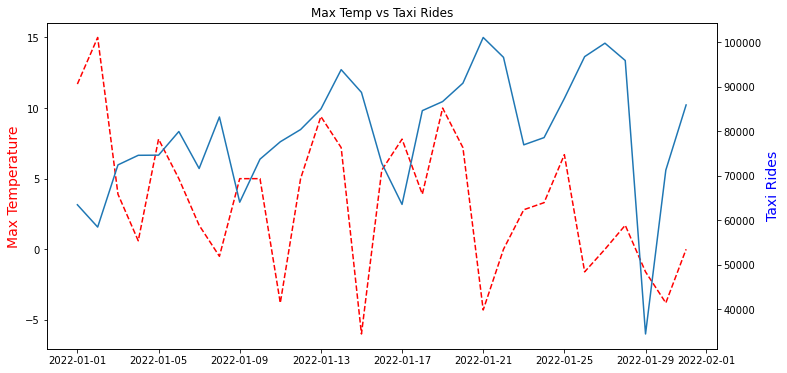

In [273]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.title('Max Temp vs Taxi Rides')

ax1 = plt.gca()
ax2 = plt.twinx()

ax1.set_ylabel('Max Temperature', color='r', fontsize=14)
ax2.set_ylabel('Taxi Rides', color='b', fontsize=14)

ax1.plot(merged_df[['TMAX Celsius']], color='red', linestyle='--')
ax2.plot(merged_df[['Vendor']])

We can additionally have a scatter plot of the two attributes.

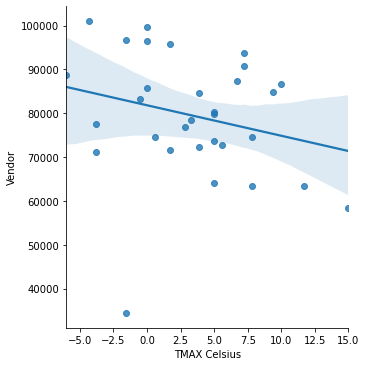

In [276]:
sns.lmplot(data=merged_df, y='Vendor' , x='TMAX Celsius')

We see that people preferred less taxi rides as the weather got more hot.